In [1]:
# Datasets
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from IPython.display import display, Latex

from pandas_datareader.data import DataReader
import pandas as pd
import numpy as np

In [2]:
# Get the data
start = '1948-01'
end = '2008-01'
us_gnp = DataReader('GNPC96', 'fred', start=start, end=end)
us_gnp_deflator = DataReader('GNPDEF', 'fred', start=start, end=end)
us_monetary_base = DataReader('AMBSL', 'fred', start=start, end=end).resample('QS').mean()
recessions = DataReader('USRECQ', 'fred', start=start, end=end).resample('QS').last().values[:,0]

In [3]:
# recessions

In [4]:
# construct the dataframe
dta = pd.concat(map(np.log, (us_gnp, us_gnp_deflator, us_monetary_base)), axis=1)
dta.columns = ['US GNP', 'US Prices', 'US monetary base']
dates = dta.index._mpl_repr()
dta.head()

,US GNP,US Prices,US monetary base
DATE,,,
1948-01-01,7.603009,2.591516,3.515121
1948-04-01,7.619339,2.600317,3.497699
1948-07-01,7.624914,2.618563,3.508895
1948-10-01,7.625972,2.621548,3.516488
1949-01-01,7.612027,2.616300,3.495325


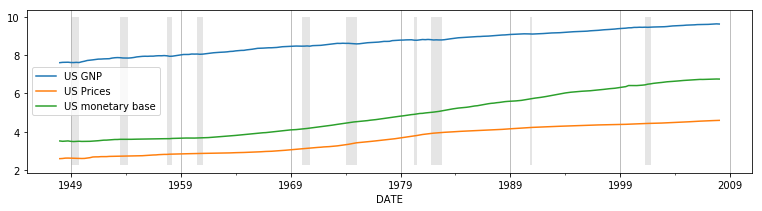

In [5]:
# plot the data
ax = dta.plot(figsize=(13,3))
ylim = ax.get_ylim()
ax.xaxis.grid()
ax.fill_between(dates, ylim[0]+1e-5, ylim[1]+1e-5, recessions, facecolor='k', alpha=0.1)

In [6]:
# Model specifications

# Unrestrical model, using string specification
unrestricted_model = {'level':'local linear trend',
                     'cycle':True,
                     'damped_cycle': True,
                     'stochastic_cycle':True}

# Unrestricted model, setting components directly
# This is an equivalent, but less convenient, way to specify a
# local linear trend model with a stochastic damped cycle:
# unrestricted_model = {
#     'irregular': True, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True,
#     'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
# }

# The restricted model forces a smooth trend
restricted_model = {'level':'smooth trend', 
                    'cycle':True, 
                    'damped_cycle':True,
                   'stochastic_cycle':True}

# Restricted model, setting components directly
# This is an equivalent, but less convenient, way to specify a
# smooth trend model with a stochastic damped cycle. Notice
# that the difference from the local linear trend model is that
# `stochastic_level=False` here.
# unrestricted_model = {
#     'irregular': True, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True,
#     'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
# }


In [7]:
# Output
output_mod = sm.tsa.UnobservedComponents(dta['US GNP'], **unrestricted_model)
output_res = output_mod.fit(method='powell', disp=False)

In [8]:
# Prices
prices_mod = sm.tsa.UnobservedComponents(dta['US Prices'], **unrestricted_model)
prices_res = prices_mod.fit(method='powell', disp=False)

prices_restricted_mod = sm.tsa.UnobservedComponents(dta['US Prices'], **restricted_model)
prices_restricted_res = prices_restricted_mod.fit(method='powell', disp=False)

In [9]:
# Money
money_mod = sm.tsa.UnobservedComponents(dta['US monetary base'], **unrestricted_model)
money_res = money_mod.fit(method='powell', disp=False)

money_restricted_mod = sm.tsa.UnobservedComponents(dta['US monetary base'], **restricted_model)
money_restricted_res = money_restricted_mod.fit(method='powell', disp=False)

In [10]:
print(output_res.summary())

                            Unobserved Components Results                            
Dep. Variable:                        US GNP   No. Observations:                  241
Model:                    local linear trend   Log Likelihood                 770.200
                   + damped stochastic cycle   AIC                          -1528.401
Date:                       Thu, 19 Jul 2018   BIC                          -1507.592
Time:                               23:57:48   HQIC                         -1520.014
Sample:                           01-01-1948                                         
                                - 01-01-2008                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  4.798e-08   7.26e-06      0.007      0

/Users/gaoziyao/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/structural.py:1676: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


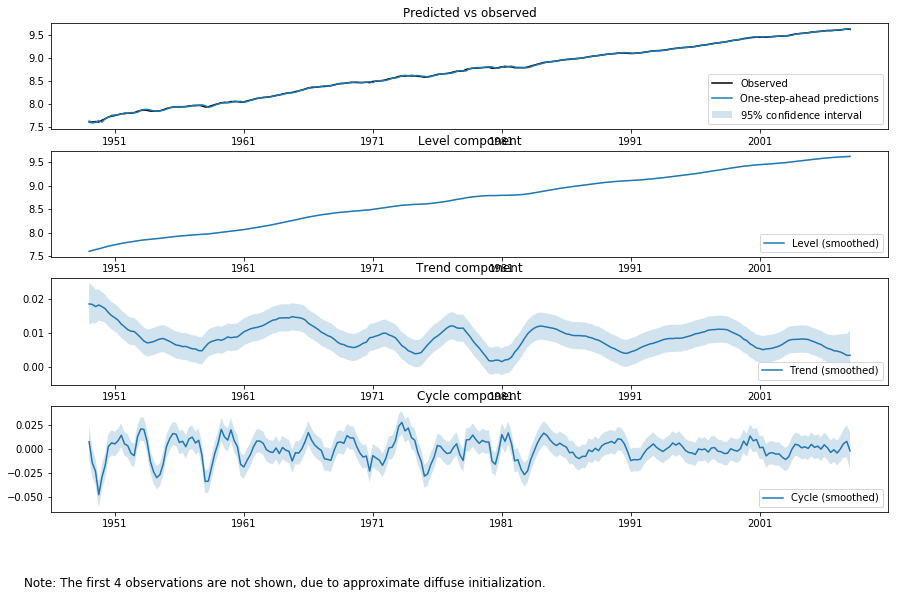

In [11]:
fig = output_res.plot_components(legend_loc='lower right', figsize=(15, 9));

In [12]:
# Create Table I
table_i = np.zeros((5,6))

start = dta.index[0]
end = dta.index[-1]
time_range = '%d:%d-%d:%d' % (start.year, start.quarter, end.year, end.quarter)
models = [
    ('US GNP', time_range, 'None'),
    ('US Prices', time_range, 'None'),
    ('US Prices', time_range, r'$\sigma_\eta^2 = 0$'),
    ('US monetary base', time_range, 'None'),
    ('US monetary base', time_range, r'$\sigma_\eta^2 = 0$'),
]
index = pd.MultiIndex.from_tuples(models, names=['Series', 'Time range', 'Restrictions'])
parameter_symbols = [
    r'$\sigma_\zeta^2$', r'$\sigma_\eta^2$', r'$\sigma_\kappa^2$', r'$\rho$',
    r'$2 \pi / \lambda_c$', r'$\sigma_\varepsilon^2$',
]

i = 0
for res in (output_res, prices_res, prices_restricted_res, money_res, money_restricted_res):
    if res.model.stochastic_level:
        (sigma_irregular, sigma_level, sigma_trend,
         sigma_cycle, frequency_cycle, damping_cycle) = res.params
    else:
        (sigma_irregular, sigma_level,
         sigma_cycle, frequency_cycle, damping_cycle) = res.params
        sigma_trend = np.nan
    period_cycle = 2 * np.pi / frequency_cycle
    
    table_i[i, :] = [
        sigma_level*1e7, sigma_trend*1e7,
        sigma_cycle*1e7, damping_cycle, period_cycle,
        sigma_irregular*1e7
    ]
    i += 1
    
pd.set_option('float_format', lambda x: '%.4g' % np.round(x, 2) if not np.isnan(x) else '-')
table_i = pd.DataFrame(table_i, index=index, columns=parameter_symbols)
table_i

$\sigma_\zeta^2$  \
Series           Time range    Restrictions                            
US GNP           1948:1-2008:1 None                            73.18   
US Prices        1948:1-2008:1 None                             15.1   
                               $\sigma_\eta^2 = 0$             41.18   
US monetary base 1948:1-2008:1 None                            61.13   
                               $\sigma_\eta^2 = 0$             18.92   

                                                    $\sigma_\eta^2$  \
Series           Time range    Restrictions                           
US GNP           1948:1-2008:1 None                           30.07   
US Prices        1948:1-2008:1 None                           41.91   
                               $\sigma_\eta^2 = 0$                -   
US monetary base 1948:1-2008:1 None                           18.69   
                               $\sigma_\eta^2 = 0$                -   

                                                    $\sigma_\kappa^2$  $\rho$  \
Series           Time range    Restrictions                                     
US GNP           1948:1-2008:1 None                             383.6    0.86   
US Prices        1948:1-2008:1 None                              0.05    0.92   
                               $\sigma_\eta^2 = 0$               0.01    0.92   
US monetary base 1948:1-2008:1 None                             199.4    0.89   
                               $\sigma_\eta^2 = 0$                247    0.89   

                                                    $2 \pi / \lambda_c$  \
Series           Time range    Restrictions                               
US GNP           1948:1-2008:1 None                               13.82   
US Prices        1948:1-2008:1 None                                9.93   
                               $\sigma_\eta^2 = 0$                 9.96   
US monetary base 1948:1-2008:1 None                               23.31   
                               $\sigma_\eta^2 = 0$                23.81   

                                                    $\sigma_\varepsilon^2$  
Series           Time range    Restrictions                                 
US GNP           1948:1-2008:1 None                                   0.48  
US Prices        1948:1-2008:1 None                                  18.88  
                               $\sigma_\eta^2 = 0$                   23.81  
US monetary base 1948:1-2008:1 None                                      0  
                               $\sigma_\eta^2 = 0$                       0